# Local Maximum and Minimum Surface Temperature
 
```{glue:figure} trend_fig_max_min
:scale: 50%
:align: right
```

## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os.path as op
import sys
import contextlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from myst_nb import glue 

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive, fig_int_to_glue
from ind_setup.plotting import plot_bar_probs, fontsize
from ind_setup.tables import get_data_metrics, plot_df_table

sys.path.append("../../../functions")
from data_downloaders import GHCN

## Define location and variables of interest

In [3]:
country = 'Palau'
vars_interest = ['TMIN', 'TMAX']

## Get Data

In [4]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

## Observations from Koror Station

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

The data used for this analysis comes from the GHCN (Global Historical Climatology Network)-Daily database. <br>
This a database that addresses the critical need for historical daily temperature, precipitation, and snow records over global land areas. GHCN-Daily is a
composite of climate records from numerous sources that were merged and then subjected to a suite of
quality assurance reviews. The archive includes over 40 meteorological elements including temperature daily maximum/minimum, temperature at observation time,
precipitation and more.

In [5]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

In [6]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_min = GHCN.extract_dict_data_var(GHCND_dir, 'TMIN', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    dict_max = GHCN.extract_dict_data_var(GHCND_dir, 'TMAX', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    st_data = pd.concat([dict_min['data'], (dict_max['data'])], axis=1).dropna()
    st_data['diff'] = st_data['TMAX'] - st_data['TMIN']
    st_data['TMEAN'] = (st_data['TMAX'] + st_data['TMIN'])/2
    st_data.to_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))
else:
    st_data = pd.read_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))

In [7]:
st_data = st_data.resample('Y').mean()
glue("n_years", len(np.unique(st_data.index.year)), display=False)
glue("start_year", st_data.dropna().index[0].year, display=False)
glue("end_year", st_data.dropna().index[-1].year, display=False)

## Plotting

At this piece of code we will plot the Mean annual temperature over time and its associated trend

The following plot represent the average minimum and maximum temperature over time

### Minimum Temperatures

In [8]:
dict_plot = [{'data' : st_data, 'var' : 'TMIN', 'ax' : 1, 'label' : 'TMIN'},
        ]

In [9]:
fig, TRENDS = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (24, 11), return_trend = True)
fig.write_html(op.join(path_figs, 'F3_ST_min.html'), include_plotlyjs="cdn")

### Maximum Temperatures

In [10]:
dict_plot = [{'data' : st_data, 'var' : 'TMAX', 'ax' : 2, 'label' : 'TMAX'},
        ]

In [11]:
fig, TRENDS = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (24, 11), return_trend = True)
fig.write_html(op.join(path_figs, 'F3_ST_max.html'), include_plotlyjs="cdn")

### Minimum and Maximum Temperatures

In [12]:
dict_plot = [{'data' : st_data, 'var' : 'TMIN', 'ax' : 1, 'label' : 'TMIN'},
        {'data' : st_data, 'var' : 'TMAX', 'ax' : 2, 'label' : 'TMAX'},
        # {'data' : st_data, 'var' : 'diff', 'ax' : 1, 'label' : 'Difference TMAX - TMIN'}
        ]

In [13]:
fig, TRENDS = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (24, 11), return_trend = True)
fig.write_html(op.join(path_figs, 'F3_ST_min_max.html'), include_plotlyjs="cdn")

glue("trend_min", float(TRENDS[0]), display=False)
glue("trend_max", float(TRENDS[1]), display=False)

glue("change_min", float(TRENDS[0]*len(np.unique(st_data.index.year))), display=False)
glue("change_max", float(TRENDS[1]*len(np.unique(st_data.index.year))), display=False)

glue("trend_fig_max_min", fig_int_to_glue(fig), display=False)

**Fig.** Annual maximum (red) and minimum (blue) temperature at Koror. The solid black line represents the trend, which is  statistically significant (p < 0.05).  The dashed black line represents a trend that is not statistically significant.  

### Generate table
The final step is to generate a table sumarizing different metrics of the data analyzed in the plots above

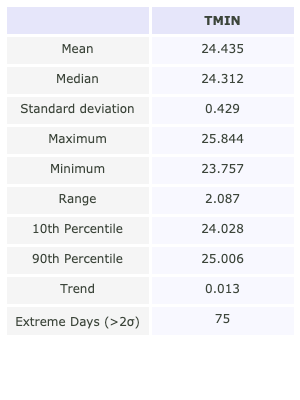

In [14]:
var = 'TMIN'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))

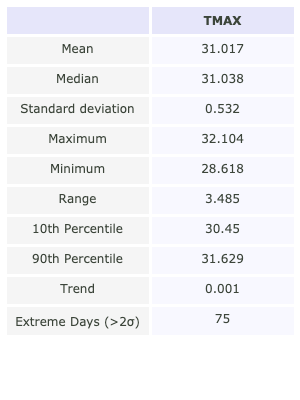

In [15]:
var = 'TMAX'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))

## Difference temperature

The following plot represents the avergae difference between the minimum and maximum temperature over time. The decreasing trend means that the daily variability is decreasing over time

In [16]:
dict_plot = [{'data' : st_data, 'var' : 'diff', 'ax' : 1, 'label' : 'Difference TMAX - TMIN'}]
fig, trend = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12), return_trend = True)
glue("trend_diff", float(trend[0]), display=False)


**Fig.** Annual maximum of the difference of the maximum and minimum temperature within each day

### Generate table
The final step is to generate a table sumarizing different metrics of the data analyzed in the plots above

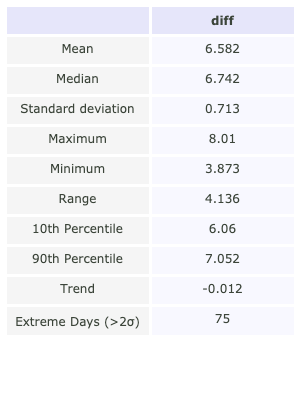

In [17]:

var = 'diff'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))